**Titanic Report**

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [150]:
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6



*   Preenchendo valores que estão vazios
*   Criando/combinando atributos



In [151]:
def ajustando_df(df):
  df['Title'] = df['Name'].str.extract(r'(Mr|Mrs|Miss|Ms|Dr|Rev|Major)',expand=True)
  df.groupby('Title')['Age'].median()
  df['family_size'] = df['SibSp'] + df['Parch'] + 1
  df['is_alone'] = np.where(df['family_size'] == 1, 1, 0)
  df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
  df.drop(columns=['Name','Cabin','Ticket','Title'],inplace=True)
  df.dropna(subset=['Embarked'],inplace=True)
  df['Age'] = df['Age'].fillna(df['Age'].median())
  return df

In [152]:
def normalizar_df(df):
  scaler = LabelEncoder()
  df['Sex'] = scaler.fit_transform(df[['Sex']])

  scaler = MinMaxScaler()
  df['Age'] = scaler.fit_transform(df[['Age']])

  scaler = MinMaxScaler()
  df['Fare'] = scaler.fit_transform(df[['Fare']])

  scaler = MinMaxScaler()
  df['SibSp'] = scaler.fit_transform(df[['SibSp']])

  scaler = MinMaxScaler()
  df['family_size'] = scaler.fit_transform(df[['family_size']])

  scaler = MinMaxScaler()
  df['Parch'] = scaler.fit_transform(df[['Parch']])

  df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', drop_first=True)

  df['Pclass_Sex'] = df['Pclass'] * df['Sex']
  df['Fare_Pclass'] = df['Fare'] * df['Pclass']

  return df

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,family_size,is_alone,Embarked_Q,Embarked_S,Pclass_Sex,Fare_Pclass
0,1,0,3,1,0.268139,0.125,0.000000,0.014151,0.1,0,False,True,3,0.042453
1,2,1,1,0,0.470032,0.125,0.000000,0.139136,0.1,0,False,False,0,0.139136
2,3,1,3,0,0.318612,0.000,0.000000,0.015469,0.0,1,False,True,0,0.046406
3,4,1,1,0,0.432177,0.125,0.000000,0.103644,0.1,0,False,True,0,0.103644
4,5,0,3,1,0.432177,0.000,0.000000,0.015713,0.0,1,False,True,3,0.047138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,0.331230,0.000,0.000000,0.025374,0.0,1,False,True,2,0.050749
887,888,1,1,0,0.230284,0.000,0.000000,0.058556,0.0,1,False,True,0,0.058556
888,889,0,3,0,0.255521,0.125,0.333333,0.045771,0.3,0,False,True,0,0.137314
889,890,1,1,1,0.318612,0.000,0.000000,0.058556,0.0,1,False,False,1,0.058556


,count
Survived,
0,549
1,340


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,family_size,is_alone,Pclass_Sex,Fare_Pclass
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.649044,0.375366,0.065523,0.063742,0.062649,0.090664,0.601800,1.551181,0.100481
std,256.998173,0.486260,0.834700,0.477538,0.149854,0.137963,0.134460,0.097003,0.161470,0.489803,1.316014,0.100752
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,0.000000,0.268139,0.000000,0.000000,0.015412,0.000000,0.000000,0.000000,0.046235
50%,446.000000,0.000000,3.000000,1.000000,0.381703,0.000000,0.000000,0.028213,0.000000,1.000000,2.000000,0.055628
75%,668.000000,1.000000,3.000000,1.000000,0.432177,0.125000,0.000000,0.060508,0.100000,1.000000,3.000000,0.113168
max,891.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


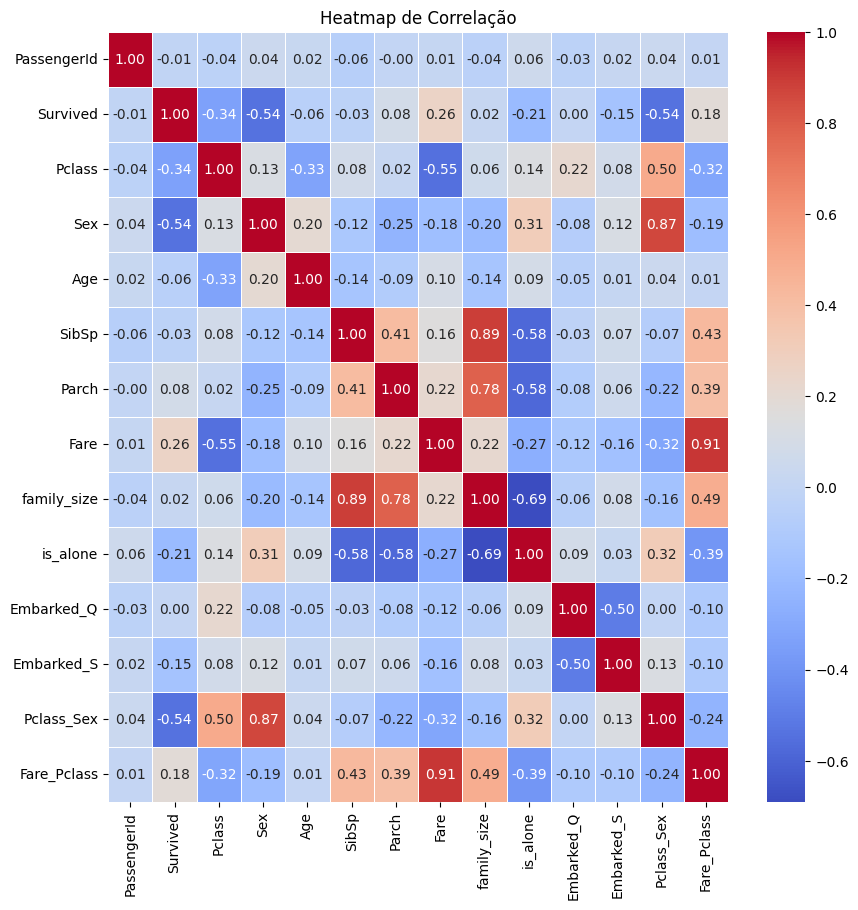

In [153]:
df = ajustando_df(df)
df = normalizar_df(df)

display(df)
display(df['Survived'].value_counts())
display(df.describe())

#Heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap de Correlação")
plt.show()



*   Identificando os melhores atributos



In [154]:
y = df['Survived']
df_new = df.drop(columns=['Survived','PassengerId'])

# Selecionar as 6 melhores features usando ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=6)
X = selector.fit_transform(df_new, y)

mask = selector.get_support()
selected_features = df_new.columns[mask]

print("Features escolhidas:", list(selected_features))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

Features escolhidas: ['Pclass', 'Sex', 'Fare', 'is_alone', 'Pclass_Sex', 'Fare_Pclass']




*   Testando modelos para identificar qual terá o melhor desempenho



**kNN**

k: 1 , acuracia: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       165
           1       0.72      0.63      0.67       102

    accuracy                           0.76       267
   macro avg       0.75      0.74      0.74       267
weighted avg       0.76      0.76      0.76       267



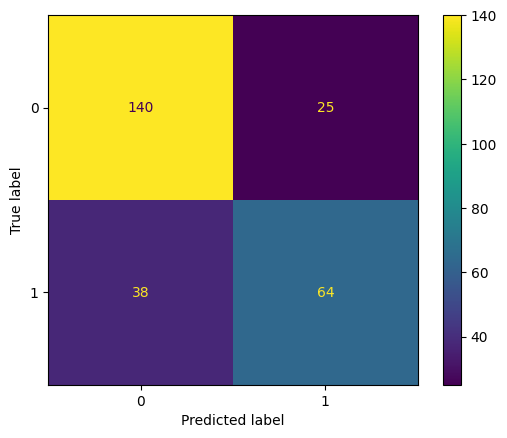

k: 2 , acuracia: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       165
           1       0.84      0.47      0.60       102

    accuracy                           0.76       267
   macro avg       0.79      0.71      0.72       267
weighted avg       0.78      0.76      0.74       267



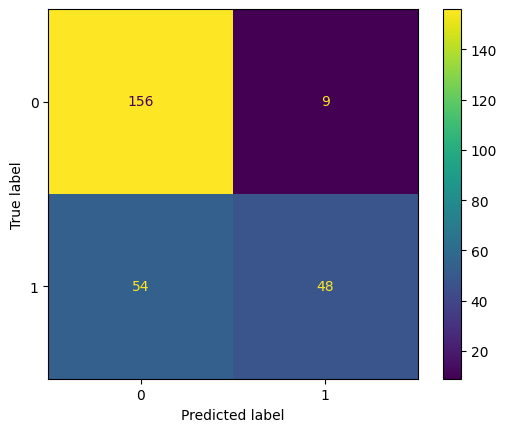

k: 3 , acuracia: 0.7827715355805244
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       165
           1       0.77      0.62      0.68       102

    accuracy                           0.78       267
   macro avg       0.78      0.75      0.76       267
weighted avg       0.78      0.78      0.78       267



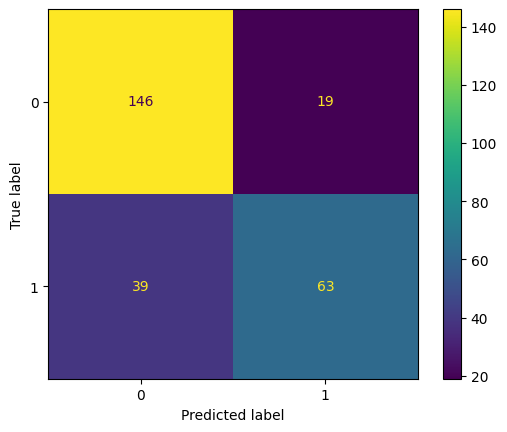

k: 4 , acuracia: 0.7565543071161048
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       165
           1       0.76      0.53      0.62       102

    accuracy                           0.76       267
   macro avg       0.76      0.71      0.72       267
weighted avg       0.76      0.76      0.75       267



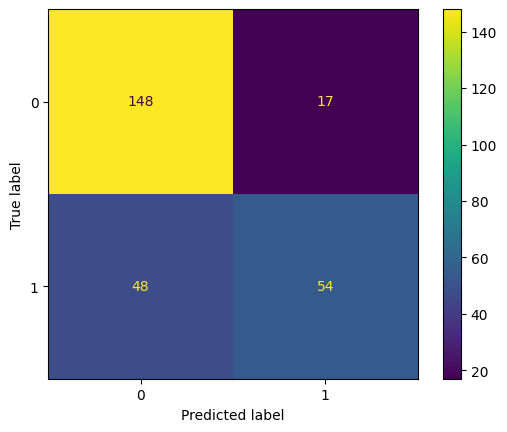

k: 5 , acuracia: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       165
           1       0.72      0.62      0.67       102

    accuracy                           0.76       267
   macro avg       0.75      0.74      0.74       267
weighted avg       0.76      0.76      0.76       267



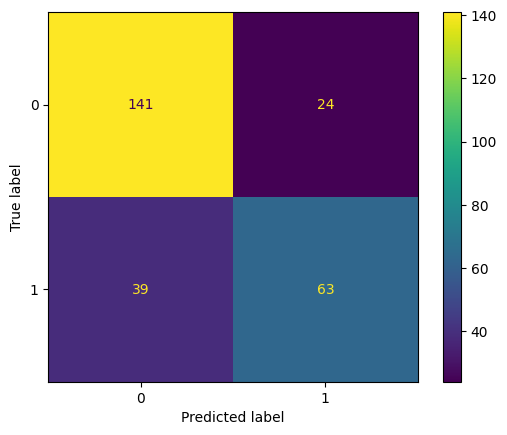

k: 6 , acuracia: 0.7827715355805244
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       165
           1       0.82      0.55      0.66       102

    accuracy                           0.78       267
   macro avg       0.80      0.74      0.75       267
weighted avg       0.79      0.78      0.77       267



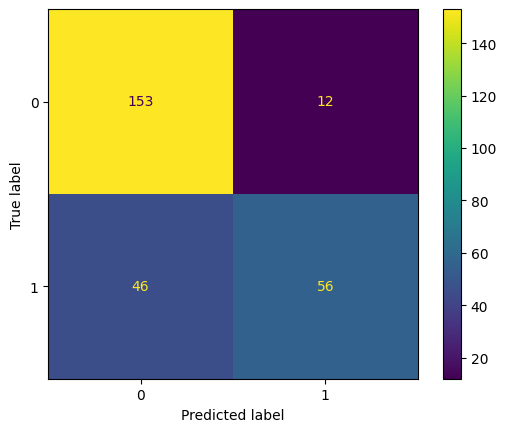

k: 7 , acuracia: 0.7602996254681648
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       165
           1       0.74      0.58      0.65       102

    accuracy                           0.76       267
   macro avg       0.75      0.73      0.73       267
weighted avg       0.76      0.76      0.75       267



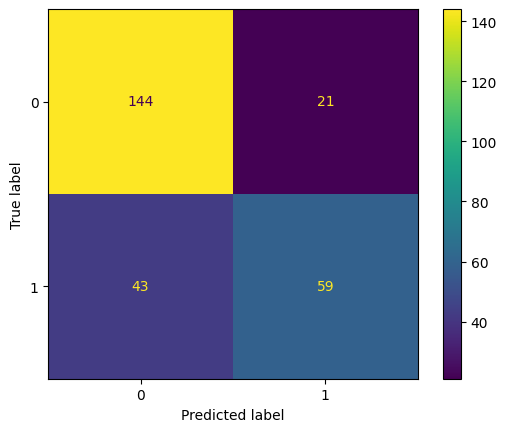

k: 8 , acuracia: 0.7865168539325843
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       165
           1       0.81      0.58      0.67       102

    accuracy                           0.79       267
   macro avg       0.79      0.75      0.76       267
weighted avg       0.79      0.79      0.78       267



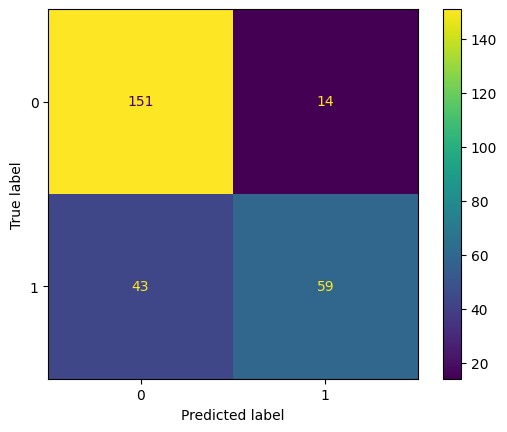

k: 9 , acuracia: 0.7640449438202247
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       165
           1       0.71      0.64      0.67       102

    accuracy                           0.76       267
   macro avg       0.75      0.74      0.74       267
weighted avg       0.76      0.76      0.76       267



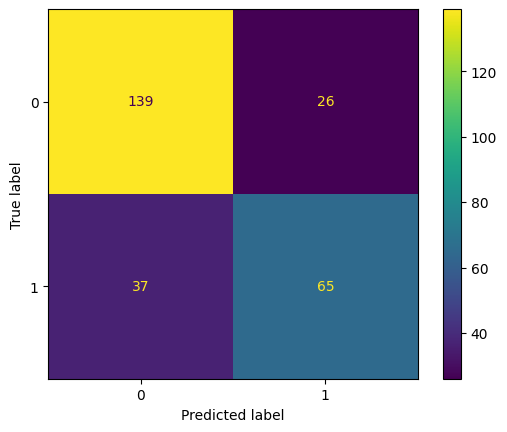

k: 10 , acuracia: 0.7677902621722846
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       165
           1       0.75      0.59      0.66       102

    accuracy                           0.77       267
   macro avg       0.76      0.73      0.74       267
weighted avg       0.77      0.77      0.76       267



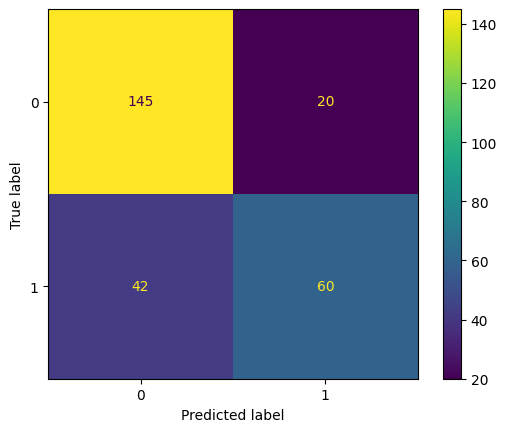

Melhor k: 8, acuracia: 0.7865168539325843


In [155]:
k_valores = np.arange(1, 11)
acc = []
for k in k_valores:
  knn = KNeighborsClassifier(n_neighbors=k, metric='cityblock') # 'euclidean', 'cityblock', 'chebyshev'
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  print(f'k: {k} , acuracia: {accuracy_score(y_test,y_pred)}')
  print(classification_report(y_test, y_pred))
  acc.append(accuracy_score(y_test,y_pred))
  cm = confusion_matrix(y_test,y_pred)
  cmd = ConfusionMatrixDisplay(cm, display_labels=list(df['Survived'].value_counts().index))
  # plota a matriz de confusão
  cmd.plot()
  plt.show()
acc = np.array(acc)
print(f'Melhor k: {k_valores[acc.argmax()]}, acuracia: {acc.max()}')

* Árvore de decisão **negrito**

Decision Tree Accuracy: 0.7940074906367042
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       165
           1       0.79      0.63      0.70       102

    accuracy                           0.79       267
   macro avg       0.79      0.76      0.77       267
weighted avg       0.79      0.79      0.79       267



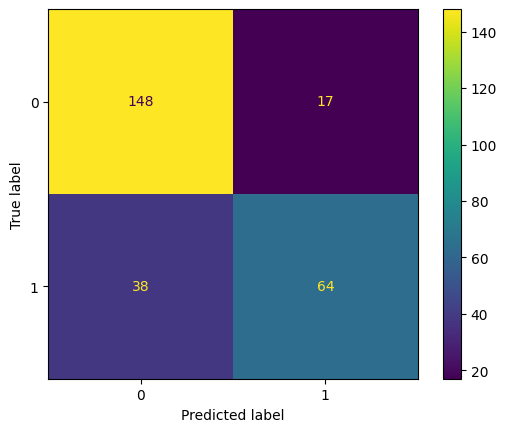

In [156]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test,y_pred_dt)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(df['Survived'].value_counts().index))
# plota a matriz de confusão
cmd.plot()
plt.show()

* **Naive Bayes**

Naive Bayes Accuracy: 0.7453183520599251
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       165
           1       0.64      0.75      0.69       102

    accuracy                           0.75       267
   macro avg       0.74      0.75      0.74       267
weighted avg       0.76      0.75      0.75       267



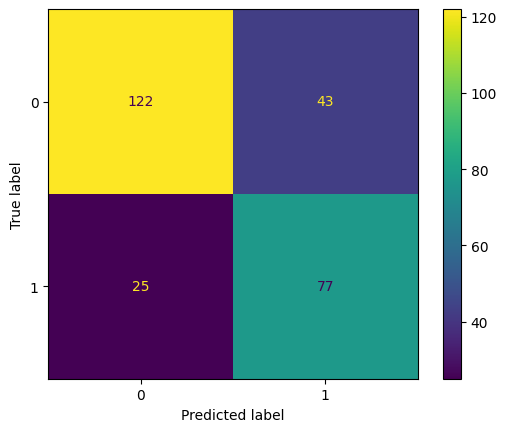

In [157]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
cm = confusion_matrix(y_test,y_pred_nb)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(df['Survived'].value_counts().index))
# plota a matriz de confusão
cmd.plot()
plt.show()

* **SVM**

SVM Accuracy: 0.7715355805243446
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       165
           1       0.84      0.50      0.63       102

    accuracy                           0.77       267
   macro avg       0.79      0.72      0.73       267
weighted avg       0.78      0.77      0.76       267



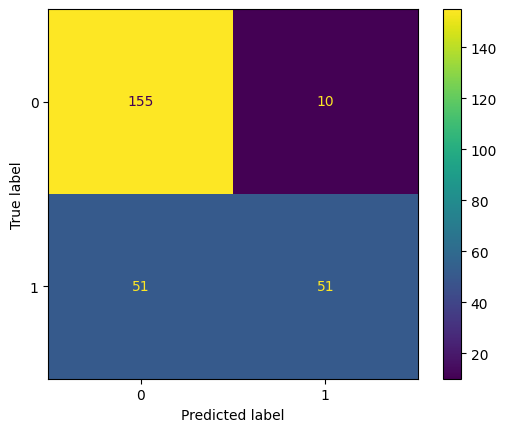

In [158]:
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test,y_pred_svm)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(df['Survived'].value_counts().index))
# plota a matriz de confusão
cmd.plot()
plt.show()

* **Random Forest**

Random Forest Accuracy: 0.7902621722846442
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       165
           1       0.77      0.65      0.70       102

    accuracy                           0.79       267
   macro avg       0.78      0.76      0.77       267
weighted avg       0.79      0.79      0.79       267



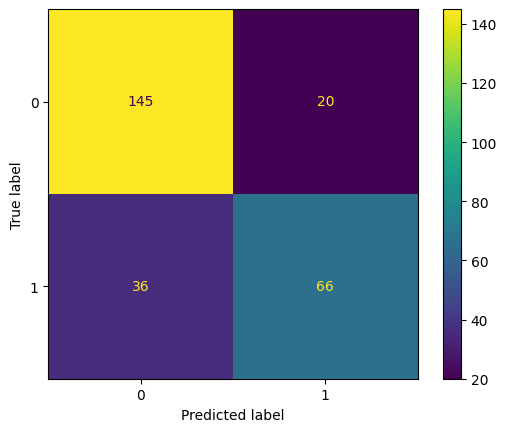

In [159]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test,y_pred_rf)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(df['Survived'].value_counts().index))
# plota a matriz de confusão
cmd.plot()
plt.show()

* **XGBoost**

In [160]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)

# Treinar modelo
xgb_model.fit(X_train, y_train)

# Fazer previsões
y_pred_xgb= xgb_model.predict(X_test)

# Avaliar
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Acurácia: 0.8164794007490637
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       165
           1       0.80      0.69      0.74       102

    accuracy                           0.82       267
   macro avg       0.81      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



In [161]:
passengers = df_test['PassengerId']
df_test = ajustando_df(df_test)
df_test = normalizar_df(df_test)
df_test = df_test[['Pclass', 'Sex', 'Fare', 'is_alone', 'Pclass_Sex', 'Fare_Pclass']]
df_test.head()


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Pclass,Sex,Fare,is_alone,Pclass_Sex,Fare_Pclass
0,3,1,0.015282,1,3,0.045845
1,3,0,0.013663,0,0,0.040989
2,2,1,0.018909,1,2,0.037817
3,3,1,0.016908,1,3,0.050724
4,3,0,0.023984,0,0,0.071951


In [165]:
labels = xgb_model.predict(df_test)
submission_df = pd.DataFrame({'PassengerId': passengers, 'Survived': labels})
submission_df.to_csv('submission.csv', index=False)